In [1]:
### ~~~~~ Libraries ~~~~~ ###

import os # makedir
import glob # use UNIX-style patterns to find files in directory

import numpy as np
import numpy.matlib as npm

import scipy
import scipy.stats # for multivariate_normal
import scipy.io # Need this to load .mat files

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.mlab as mlab # Numerical python functions written for compatability with MATLAB commands with the same names.Numerical python functions written for compatability with MATLAB commands with the same names.
from cycler import cycler

In [2]:
### ~~~~~ Data Generation ~~~~~ ###

# Data set that Keene asked us to generate in class
def getKeeneData(N1, N2):
    
    # Total number of observations
    N = N1+N2;

    # Parameters for Gaussian (these are unknown and we're to estimate them)
    mu1 = np.array([2,2])
    mu2 = np.array([-2,-2])
    cov = np.array([[1,0],[0,1]]) # or do identity

    # Generate data samples from Gaussian
    # Samples are nObservations-by-nFeatures
    X1 = np.random.multivariate_normal(mu1,cov,N1)
    X2 = np.random.multivariate_normal(mu2,cov,N2)                               
    X = np.concatenate((X1,X2),axis=0)
        # concatenate data into one matrix
    Y = np.concatenate(( np.ones((X1.shape[0],1)), \
                        np.zeros((X2.shape[0],1)) ),axis=0)
        # generate column vector for corresponding values (we want to predict these)

    # Convert data to matrices for simpler Python operations
    X = np.asmatrix(X)
    Y = np.asmatrix(Y)
    
    return (X,Y)

def getSpecialData():
    
    mat = scipy.io.loadmat('data.mat')
    
    X_circles = np.asmatrix(mat['circles'][0][0][0])
    Y_circles = np.asmatrix(mat['circles'][0][0][1])

    X_unimodal = np.asmatrix(mat['unimodal'][0][0][0])
    Y_unimodal = np.asmatrix(mat['unimodal'][0][0][1])
    
    X_spiral = np.asmatrix(mat['spiral'][0][0][0])
    Y_spiral = np.asmatrix(mat['spiral'][0][0][1])
    
    X_bimodal = np.asmatrix(mat['bimodal'][0][0][0])
    Y_bimodal = np.asmatrix(mat['bimodal'][0][0][1])
    
    return (X_circles,Y_circles,X_unimodal,Y_unimodal,X_spiral,Y_spiral,X_bimodal,Y_bimodal)

# Generate randomly clustered data, 2 features
# Specify K (number of clusters), sizes of clusters as a list, r (distance between clusters),
def generateClusters(K, sizes, r=3):
    
    if K > len(sizes):
        print('Specified K %d exceeds size of list %d' % (K, len(sizes)))
        return
    
    # Parameters to generate data with using for Gaussian
    mu = []
    for k in range(K):
        # Specify position of means in polar coordinates first, then go back to Cartesian
        # This is so we can evenly divide clusters
        theta = 2*np.pi*k/float(K)
        x = r*np.cos(theta)
        y = r*np.sin(theta)
        mu.append(np.array([x,y]))
    cov = np.eye(2) # just use identity for all covariances

    # Generate data samples from Gaussian
    # Samples are nObservations-by-nFeatures
    X = np.empty((0,2)) # zero rows so that there are no initial values
    for k in range(K):       
        X_k = np.random.multivariate_normal(mu[k],cov,sizes[k])
        X = np.concatenate((X,X_k),axis=0) # concatenate rows together
 
    # Convert data to matrices for simpler Python operations
    X = np.asmatrix(X)

    return X

# Generate randomly clustered data, 1 feature
def generate1DClusters(K, sizes):
    
    if K > len(sizes):
        print('Specified K %d exceeds size of list %d' % (K, len(sizes)))
        return
    
    # Parameters to generate data with using for Gaussian
    mu = []
    for k in range(K):
        # Distribute clusters so that means are evenly separated from -x_range to x_range
        # Draw it visually and you'll see that this is the formula to do this
        x_range = 50
        x = -x_range + x_range/float(K) + 2*k*x_range/float(K)
        mu.append(x)
    sigma = 1 # just use 1 for variance

    # Generate data samples from Gaussian
    # Samples are nObservations-by-nFeatures
    X = []
    for k in range(K):       
        X_k = np.random.normal(mu[k],sigma,sizes[k])
        X.append(X_k)
 
    # Convert data to matrices for simpler Python operations
    # First unravel list to make all data in one row
    # Then convert to matrix and transpose to have N rows
    X = np.asmatrix(np.ravel(X)).T

    return X

In [3]:
### ~~~~~ Plotting Functions ~~~~~ ###

# Plot original data with mean and standard deviation contours around mean
# Only works for 2 features
def plotContours(X, mu, cov, frame):
    
    # Don't plot if not 2 features
    M = X.shape[1]
    if M != 2:
        return
        
    # Set figure size and get plot axes
    figsize = (8,6)
    plt.figure(figsize=figsize)
    axes = plt.gca()

    # Plot data
    plt.scatter(X[:,0],X[:,1],color='r')
    
    # Plot each mean
    K = len(mu)
    for k in range(K):
        plt.scatter(mu[k][0],mu[k][1],color='k')
    
    # One contour plot for each mean
    n1 = 100
    n2 = 100
    x1 = np.linspace(-10,10,n1)
    x2 = np.linspace(-10,10,n2)
    X1, X2 = np.meshgrid(x1,x2)
    for k in range(len(mu)):
        # Combine X1 and X2 into one matrix with two features (unroll them first) before putting in normal
        # When combining the two raveled matrices, don't use concatenate, because ravel makes it so it's 1D, so result of concat is 1D
        #print np.array([np.ravel(X1), np.ravel(X2)])
        #print np.concatenate((np.ravel(X1),np.ravel(X2)),axis=0)
        normpdf = scipy.stats.multivariate_normal(mean=np.ravel(mu[k]),cov=cov[k])
        temp = np.array([np.ravel(X1), np.ravel(X2)])
        z = []
        for i in range(n1*n2):
            z.append(normpdf.pdf(np.ravel(temp[:,i])))
        # Reshape z to have the same dimensions as meshgrid for plot
        # NOTE: reshape can be applied to lists and still return an ndarray
        z = np.reshape(z,(n1,n2))
        plt.contour(x1,x2,z)
    
    # Plot labels and limits
    plt.title('Observations with Means from EM (Contour Plot)')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    
    # Show and save plot
    dirname = "anim/M=%d/K=%d" % (M,K) 
    figname = "EM_M=%d_K=%d_contour_%03d.png" % (M,K,frame)
    plt.savefig(dirname + '/' + figname)
    plt.show()
    
# Plot original data with colors corresponding to responsibility values
# Also plot the contour for one standard deviation away from mean
# Only works for 2 features
# Only works for 2 <= K <= 3
def plotColors(X, mu, cov, gamma, frame):
    
    # Don't plot if not 2 features
    M = X.shape[1]
    if M != 2:
        return
    
    # Don't plot if K isn't 2 or 3
    K = len(mu)
    if K > 3 or K < 2:
        return
    
    # Set figure size and get plot axes
    figsize = (8,6)
    plt.figure(figsize=figsize)
    axes = plt.gca()

    # Plot color-coded data
    N = X.shape[0]
    for n in range(N):
        r = gamma[0][n,0] # red is k = 1
        g = gamma[1][n,0] # green is k = 2
        if K == 2:
            b = 0 # fix one of the RGB values if only 2 clusters
        elif K == 3:
            b = gamma[2][n,0] # blue is k = 3
        plt.scatter(X[n,0],X[n,1],color=(r,g,b))
        
    # One contour plot for each mean
    K = len(mu)
    n1 = 100
    n2 = 100
    x1 = np.linspace(-10,10,n1)
    x2 = np.linspace(-10,10,n2)
    X1, X2 = np.meshgrid(x1,x2)
    for k in range(K):
        # Combine X1 and X2 into one matrix with two features (unroll them first) before putting in normal
        # When combining the two raveled matrices, don't use concatenate, because ravel makes it so it's 1D, so result of concat is 1D
        #print np.array([np.ravel(X1), np.ravel(X2)])
        #print np.concatenate((np.ravel(X1),np.ravel(X2)),axis=0)
        normpdf = scipy.stats.multivariate_normal(mean=np.ravel(mu[k]),cov=cov[k])
        temp = np.array([np.ravel(X1), np.ravel(X2)])
        z = []
        for i in range(n1*n2):
            z.append(normpdf.pdf(np.ravel(temp[:,i])))
        # Reshape z to have the same dimensions as meshgrid for plot
        # NOTE: reshape can be applied to lists and still return an ndarray
        z = np.reshape(z,(n1,n2))
        # Only want to plot points that are one std. dev away
        rgb = 'r' if (k == 0) else ('g' if (k == 1) else 'b');
        plt.contour(x1,x2,z,1,colors=rgb)
    
    # Plot each mean
    for k in range(K):
        plt.scatter(mu[k][0],mu[k][1],color='k')
    
    # Plot labels
    plt.title('Observations with Means from EM (Color Plot)')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    
    # Show and save plot
    dirname = "anim/M=%d/K=%d" % (M,K) 
    figname = "EM_M=%d_K=%d_color_%03d.png" % (M,K,frame)
    plt.savefig(dirname + '/' + figname)
    plt.show()

# Only works for one features
def plotHistogram(X, mu, var, histogram_scale, frame):
    
    # Don't plot if not 1 feature
    M = X.shape[1]
    if M != 1:
        return
        
    # Set figure size and get plot axes
    figsize = (8,6)
    plt.figure(figsize=figsize)
    axes = plt.gca()
    
    # Plot histogram for observations
    plt.hist(X,bins=histogram_scale*5,color='y')
    
    # Plot distribution resulting from parameters from current EM iteration
    # Plot distribution for each mean over some range x (defined to span s std.dev's from mean)
    K = len(mu)
    for k in range(K):
        n = 100 # number of points in range
        s = 3 # number of std. devs to span
        sigma_k = np.sqrt(var[k])
        # Convert mu[k], sigma_k to scalars because they are single elements nested within arrays, will cause issues
        x = np.linspace(np.asscalar(mu[k]-s*sigma_k),np.asscalar(mu[k]+s*sigma_k),n)
        #x = np.linspace(-50,50,n) # hard code range for now
        # Scale up normals (scale factor depends on size of clusters)
        rgb = 'r' if (k == 0) else ('g' if (k == 1) else 'b');
        plt.plot(x,histogram_scale*mlab.normpdf(x,np.asscalar(mu[k]),np.asscalar(sigma_k)),color=rgb)        

    # Plot labels
    plt.title('Histogram Plot with EM Distribution')
    plt.xlabel('x (1-feature observations)')
    plt.ylabel('Distribution')
    plt.xlim([-60,60])
    plt.ylim([0,histogram_scale*0.5]) # use 50% of peak distribution size for now
    
    # Show and save plot
    dirname = "anim/M=%d/K=%d" % (M,K) 
    figname = "EM_M=%d_K=%d_histogram_%03d.png" % (M,K,frame)
    plt.savefig(dirname + '/' + figname)
    plt.show()
    

In [4]:
### ~~~~~ Expectation Maximization ~~~~~ ###

# Perform Expectation-Maximization on a given observation set X
# X is an N-by-M matrix
# Specify K, the number of clusters
# Specify histogram_scale, which specifies the number of bins and scaling factor for normal distribution
def EM(X, K=2, histogram_scale=20):
    
    # Can't have 0 or less clusters, terminate algo
    if K <= 0:
        return
    
    # N observations, M features
    N = X.shape[0]
    M = X.shape[1]
    
    print "N:", N, "M:", M
    print
    print "Before EM:"
    
    # First make new directory for image files, if it doesn't exist
    dirname = "anim/M=%d/K=%d" % (M,K)
    try:
        os.makedirs(dirname)
    except:
        print ('Directory %s already exists, clearing files...') % (dirname)
        # If directory already exists, clear all files in there
        file_list = glob.glob('anim/M={}/K={}/*.png'.format(M,K))
        for f in file_list:
            os.remove(f)
    
    ### Step 1: Initialize parameters and log-likelihood ###
    
    # Initialize containers for parameters
    # mu_k is M-by-1 => mu is k-by-M-by-1
    # cov_k is M-by-M => cov is k-by-M-by-M
    # pi_k is 1-by-1 => pi is k-by-1-by-1
    # Just use k-dim lists
    mu = [np.asmatrix(np.random.rand(M,1)) for k in range(K)]
        # random mean
        # NOTE: mu's can't be the same for all K because then normpdf will be the same for all K
        # Then, nothing will change because responsibility is always equal to pi (denom cancels out with numer, leaving pi)
    cov = [npm.eye(M) for k in range(K)]
        # all covariances are identity for now
    pi = [float(1)/K for k in range(K)]
        # make pi's all the same for now, bad thing about this is that we can't use pi's as convergence check
        # NOTE: can't initialize to 0 or denom will be 0 when calculating responsibility
    
    # Initialize log-likelihood
    log_likelihood = 0
    
    # Initialize responsibilities to zero, N responsibilities for each k
    # gamma_k is N-by-1
    gamma = [npm.zeros((N,1)) for k in range(K)]
    
    # Initialize Nk's
    Nk = [0 for k in range(K)]
    
    # Make plots for initial parameters, also creates frame 0 of gif
    if M == 2:
        if K > 3:
            plotContours(X,mu,cov,0)
        elif K > 1:
            plotColors(X,mu,cov,gamma,0)
    elif M == 1:
        plotHistogram(X,mu,cov,histogram_scale,0)
    print
    
    ### Repeat steps 2 to 4 until convergence ###
    # Cap at a certain number of iterations so you don't potential get an infinite loop
    iterations = 100
    for iteration in range(iterations):
        
        # NOTE: Need to reset values to 0 before doing ANY summation
        
        # Compute the frozen multivariate normal for current mu, cov before doing anything else
        # This may save some computation time
        # Use np.ravel to make mean array-like (doesn't deal with column matrices)
        normpdf = [0 for k in range(K)]
        for k in range(K):
            normpdf[k] = scipy.stats.multivariate_normal(mean=np.ravel(mu[k]),cov=cov[k])
    
        ### Step 2: E step, update responsibilities ###
        for k in range(K):
            for n in range(N):

                # Compute denominator of responsibility
                denom = 0
                for j in range(K):
                    denom += pi[j]*normpdf[j].pdf(np.ravel(X[n,:]))
                                
                # Needed to call multivariate_normal without x as input to freeze the distribution
                # Now get the associated probability using pdf, use np.ravel again to avoid issues with input
                gamma[k][n,0] = pi[k]*normpdf[k].pdf(np.ravel(X[n,:]))/denom
                
        # Need to update Nk's after responsibilities are calculated
        for k in range(K):
            Nk[k] = 0
            for n in range(N):
                Nk[k] += gamma[k][n,0]
        
        ### Step 3: M step, update parameters using new responsibilities ###
        # X[n,:] is 1-by-M, so transpose for M-by-1

        # Update mu's
        mu_old = list(mu) # need to make a copy using list(), assignment copies the list reference, not the list itself
        for k in range(K):
            mu[k] = npm.zeros((M,1))
            for n in range(N):
                # Need to index into 2nd dim as well to get scalar (1x1 times Mx1 doesn't work)
                mu[k] += gamma[k][n,0]*X[n,:].T/float(Nk[k])
        
        # Update cov's, need new mu_k's to update cov_k's
        cov_old = list(cov)
        for k in range(K):
            cov[k] = npm.zeros((M,M))
            for n in range(N):
                cov[k] += gamma[k][n,0]*(X[n,:].T-mu[k])*(X[n,:].T-mu[k]).T/float(Nk[k])
         
        # Update pi's
        pi_old = list(pi)
        for k in range(K):
            pi[k] = Nk[k]/float(N)
                    
        # Step 4: Evaluate log likelihood
        log_likelihood_old = log_likelihood
        log_likelihood = 0
        for n in range(N):
            temp = 0;
            for k in range(K):
                temp += pi[k]*normpdf[k].pdf(np.ravel(X[n,:]))
            log_likelihood += np.log(temp)
        
        # Print stats
        print ("Iteration %d:" % (iteration+1))
        #print "Responsibility:", gamma
        #print "Nk:", Nk
        #print "mu:", mu
        #print "cov:", cov
        #print "pi:", pi
        print "Log likelihood:", log_likelihood
        
        # Plot result of EM after each iteration, also generates frame corresponding to each iteration
        if M == 2:
            if K > 3:
                plotContours(X,mu,cov,iteration+1) # Frame iteration+1, since iteration starts at 0
            elif K > 1:
                plotColors(X,mu,cov,gamma,iteration+1)
        elif M == 1:
            plotHistogram(X,mu,cov,histogram_scale,iteration+1)
        print
        
        ### Convergence test, break EM if either parameters or log likelihood converge ###
        
        if abs(log_likelihood-log_likelihood_old) < 0.001:
            print ("K-Means converged on iteration %d, log likelihood converged (old=%.5f,new=%.5f,diff=%.5f)." \
                       % (iteration+1,log_likelihood_old,log_likelihood,abs(log_likelihood-log_likelihood_old)))
            break
            
        # Commenting this out for now for smoother looking graphs
        """
        break_EM = False
        for k in range(K):
            if np.linalg.norm(mu[k]-mu_old[k],ord=2) < 0.001 or \
                np.linalg.norm(cov[k]-cov_old[k],ord=2) < 0.001:# or \
                #abs(pi[k]-pi[k]) < 0.001: # ignore this for now because pi is initialized to be the same
                    print ("K-Means converged on iteration %d, parameters converged.\nDisplaying log likelihoods: (old=%.5f,new=%.5f,diff=%.5f)" \
                           % (iteration+1,log_likelihood_old,log_likelihood,abs(log_likelihood-log_likelihood_old)))
                    break_EM = True
                    break

        if break_EM:
            break
        """
        
        # Uncomment for only one iteration
        #if iteration == 1:
        #    break
        
    frames = iteration+1
    return gamma, mu, cov, pi, log_likelihood, frames

In [5]:
### ~~~~~ Animation and File Cleanup ~~~~~ ###

# Turn saved plot images into animation
# Specify M, K just for naming purposes
# Specify number of frames so that the last frame can be delayed longer
# Specify frame rate
def generateAnimation(M, K, delay):
    
    # Only plotting for K >= 1, M = 1,2
    if K <= 0 or (M != 1 and M != 2):
        return
    
    dirname = "anim/M=%d/K=%d"% (M,K)
        # Get name of directory to plot
    
    file_list = glob.glob(dirname + '/' + '*.png')
        # Get all the pngs in the current directory
    list.sort(file_list, key=lambda x: int(x.split('_')[4].split('.png')[0]))
        # Sort the images by number, which is the 5th element delimited by '_', and exclude '.png'
    
    with open('image_list.txt', 'w') as file:         
        for item in file_list:
            file.write("%s\n" % item)
                # Write image names to text file

    plot_type = 'histogram' if M == 1 else ('contour' if K > 3 else 'color')
    gifname = "EM_M=%d_K=%d_%s" % (M,K,plot_type)
    os.system('convert @image_list.txt -delay {} {}.gif'.format(delay,gifname)) 
        # Use ImageMagick to convert list into gif
        # Check if ImageMagick is first on your computer, ex. !brew install imagemagick
        # On windows convert is 'magick'
        
    # How to change delays for a specific frame
    # 1. Clone the frame (frame 0 is first frame) and change delay, the cloned frame is inserted past the old frame
    # 2. Swap old frame with cloned frame, using - to indicate the previous frame.
    # 3. Delete the old frame which is now the next frame, using +.
    #os.system('convert {}.gif \( -clone 0 -set delay 100 \) -swap 0 +delete '.format(gifname) + \
    #                         '\( +clone -set delay 100 \) +swap +delete {}.gif'.format(gifname))
    # We only want to delay the last frame
    # +clone will make a copy of the last image in the sequence
    # +swap will switch the last two images in the sequence
    os.system('convert {}.gif \( +clone -set delay 100 \) +swap +delete {}.gif'.format(gifname,gifname))    
    
    
# Cleanup files used to generate animation
# Remove text file, all individual PNGs and their containing folders
def cleanup():
    
    os.remove('image_list.txt')
    
    # I'm kinda antsy about using shutil because it's too powerful
    # So lose access to it RIGHT AFTER deleting desired files
    # Could alternatively use glob to search through files then os.remove or os.rmdir one by one
    import shutil
    shutil.rmtree('anim')
    del shutil

----------------------------------------------------------
1-Feature Dataset
----------------------------------------------------------

----------------------------------------------------------
K = 3
----------------------------------------------------------

N: 60 M: 1

Before EM:
Directory anim/M=1/K=3 already exists, clearing files...


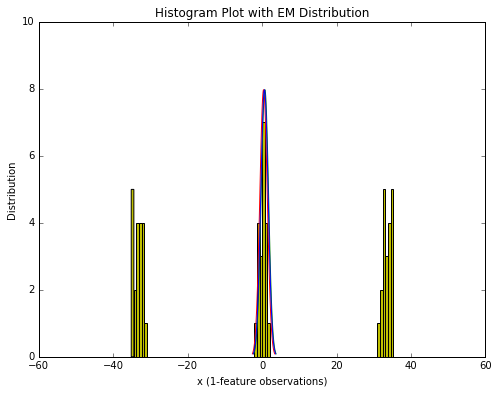


Iteration 1:
Log likelihood: -22271.3731499


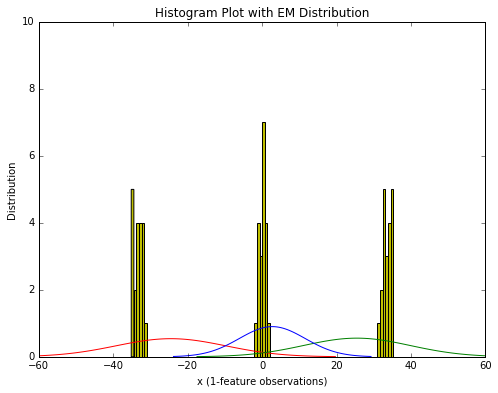


Iteration 2:
Log likelihood: -273.513894712


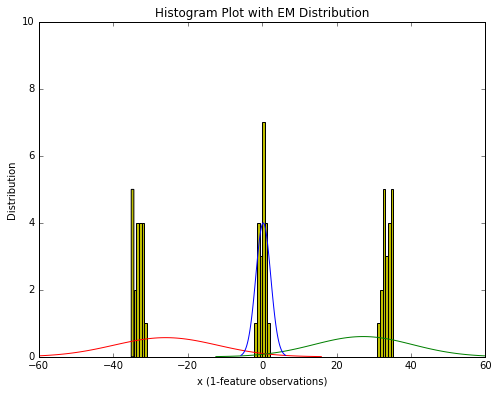


Iteration 3:
Log likelihood: -245.545749431


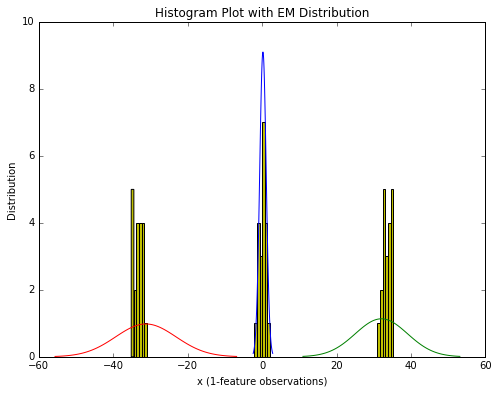


Iteration 4:
Log likelihood: -211.075240529


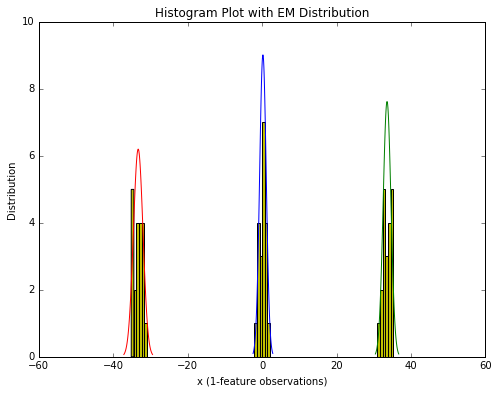


Iteration 5:
Log likelihood: -153.17884317


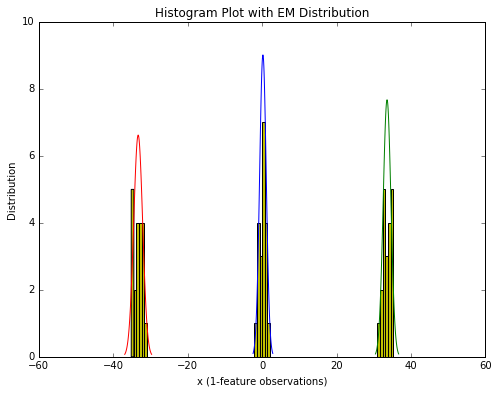


Iteration 6:
Log likelihood: -153.095365835


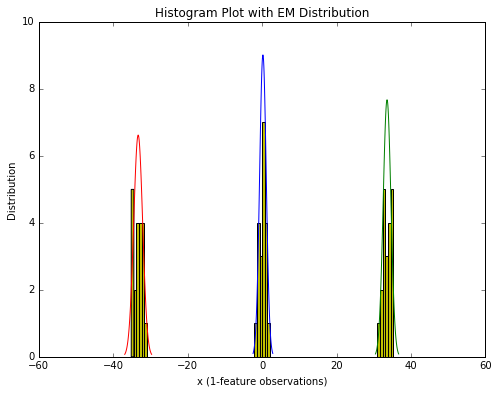


Iteration 7:
Log likelihood: -153.095365835


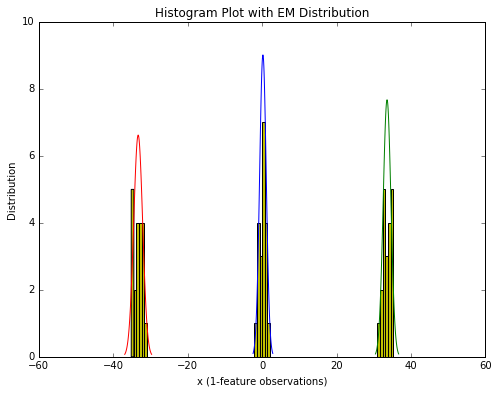


K-Means converged on iteration 7, log likelihood converged (old=-153.09537,new=-153.09537,diff=0.00000).

----------------------------------------------------------
2-Feature Datasets
----------------------------------------------------------

----------------------------------------------------------
K = 2
----------------------------------------------------------

N: 100 M: 2

Before EM:
Directory anim/M=2/K=2 already exists, clearing files...


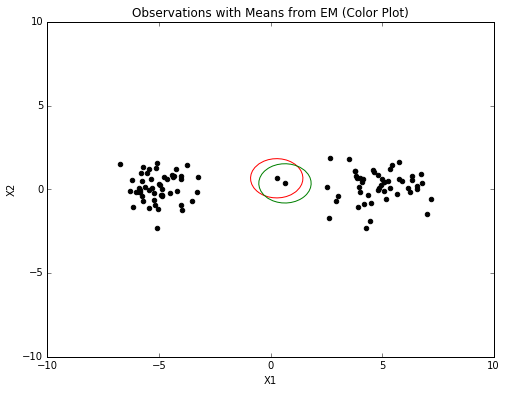


Iteration 1:
Log likelihood: -1486.69324573


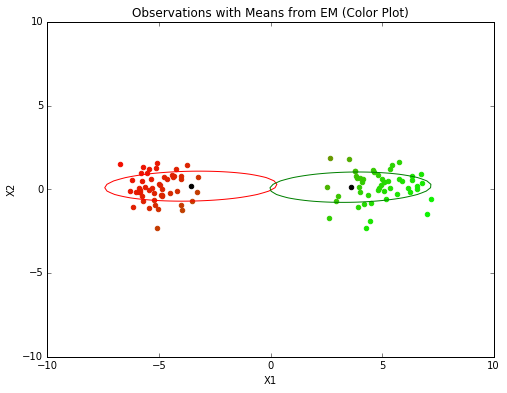


Iteration 2:
Log likelihood: -420.111755737


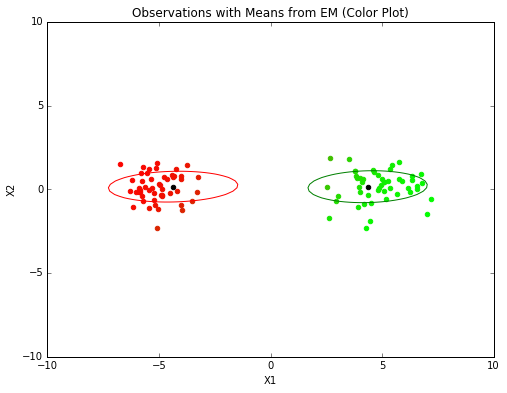


Iteration 3:
Log likelihood: -392.842644607


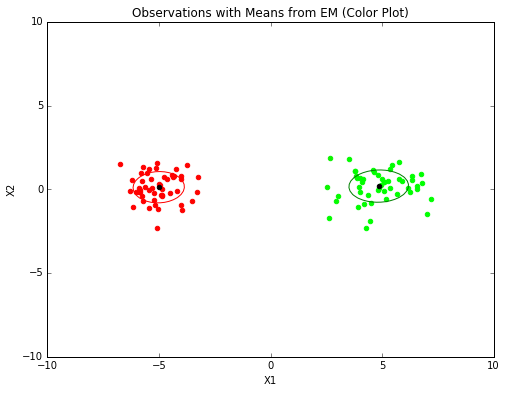


Iteration 4:
Log likelihood: -338.520650165


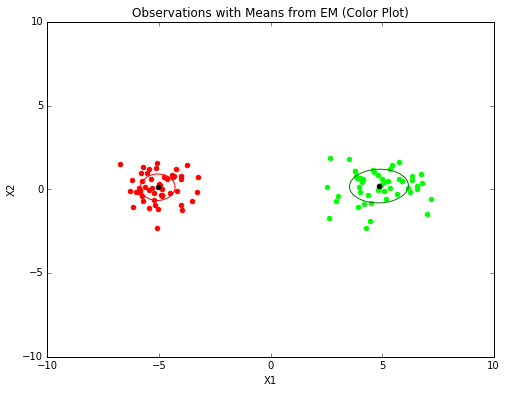


Iteration 5:
Log likelihood: -336.107553829


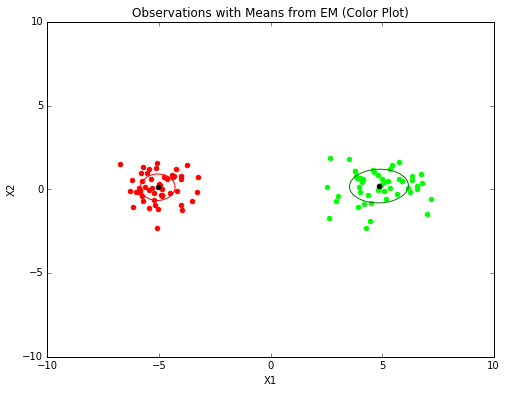


Iteration 6:
Log likelihood: -336.107553829


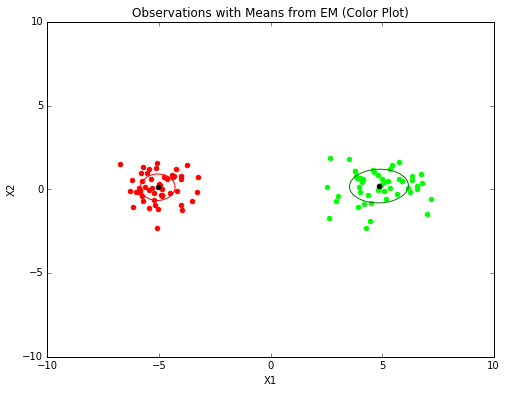


K-Means converged on iteration 6, log likelihood converged (old=-336.10755,new=-336.10755,diff=0.00000).

----------------------------------------------------------
K = 3
----------------------------------------------------------

N: 150 M: 2

Before EM:
Directory anim/M=2/K=3 already exists, clearing files...


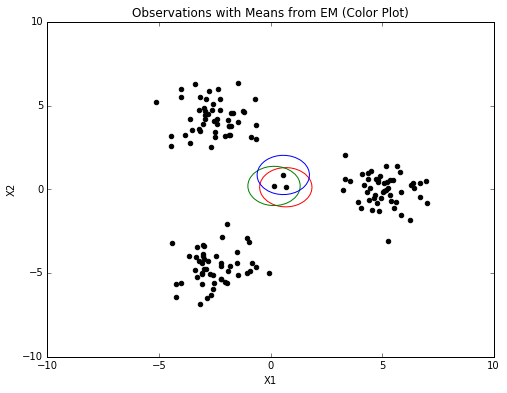


Iteration 1:
Log likelihood: -2314.04728118


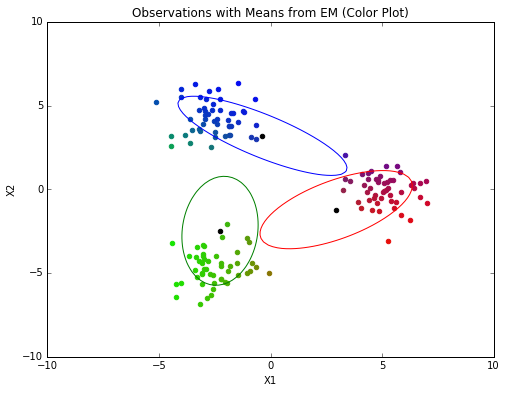


Iteration 2:
Log likelihood: -728.469465539


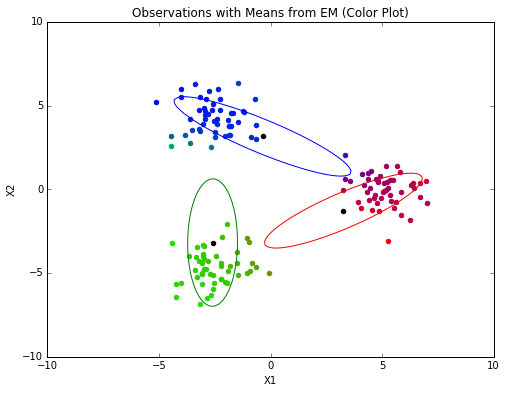


Iteration 3:
Log likelihood: -691.843769467


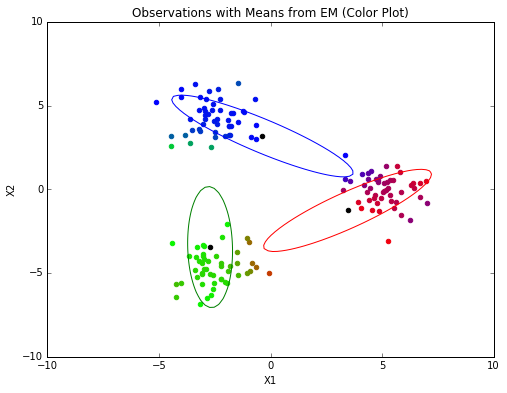


Iteration 4:
Log likelihood: -687.622878092


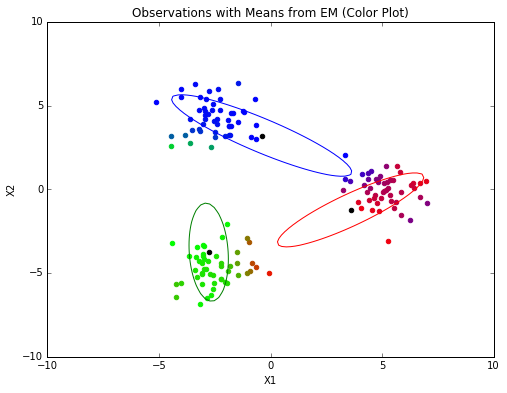


Iteration 5:
Log likelihood: -684.226472624


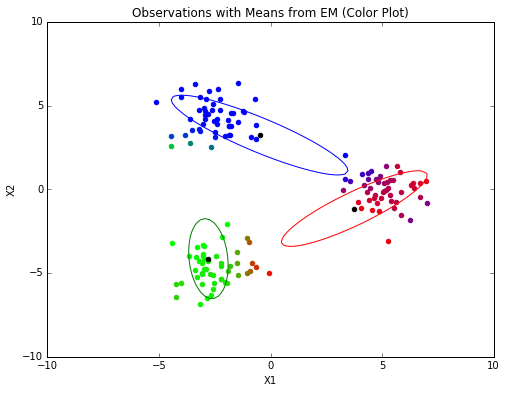


Iteration 6:
Log likelihood: -677.651010341


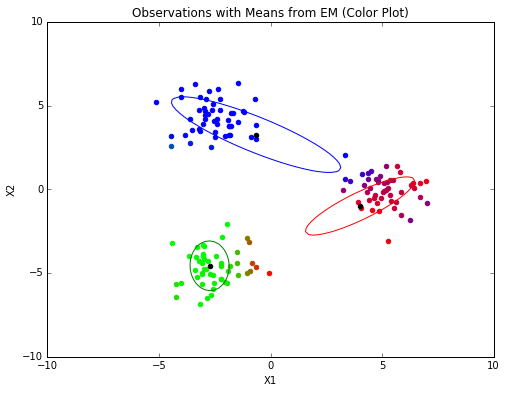


Iteration 7:
Log likelihood: -660.782566525


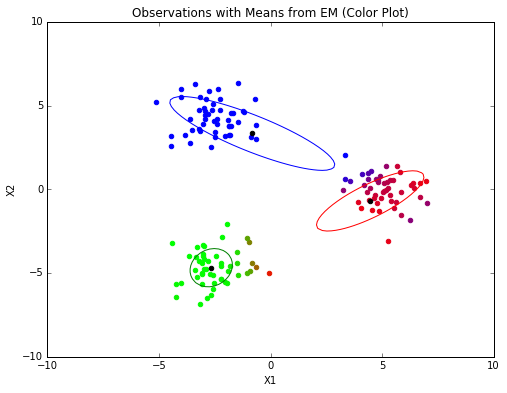


Iteration 8:
Log likelihood: -650.011320958


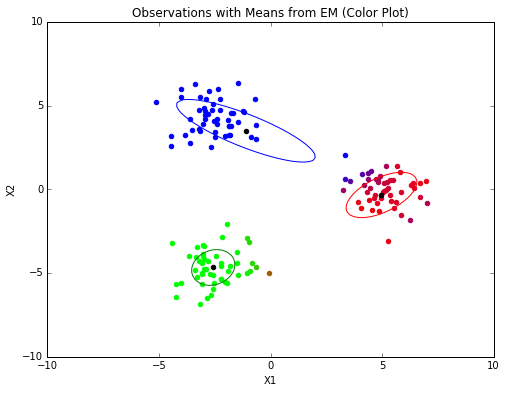


Iteration 9:
Log likelihood: -631.3936197


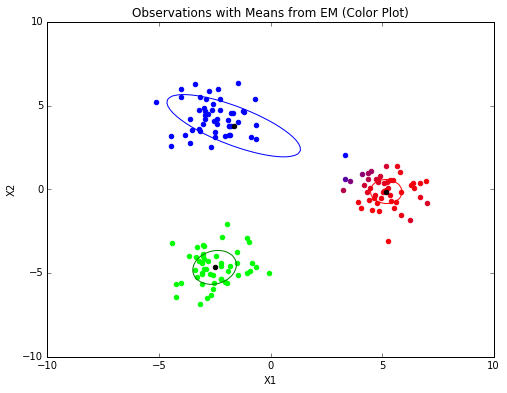


Iteration 10:
Log likelihood: -608.213518331


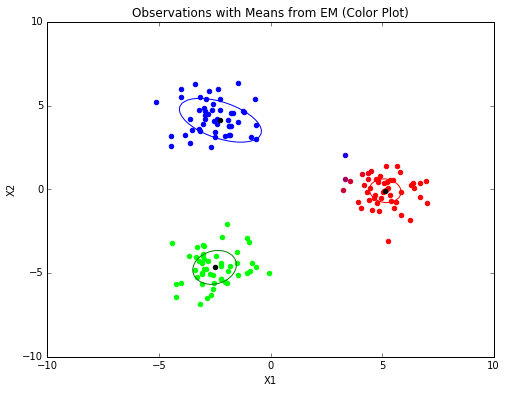


Iteration 11:
Log likelihood: -590.825424737


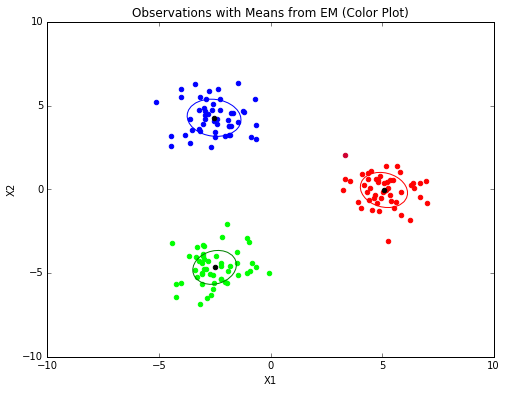


Iteration 12:
Log likelihood: -577.656379633


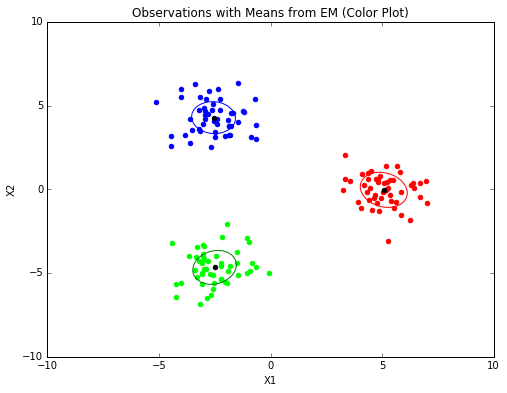


Iteration 13:
Log likelihood: -577.391174844


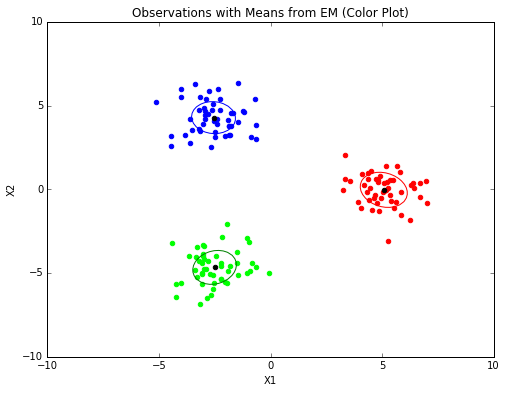


Iteration 14:
Log likelihood: -577.391174844


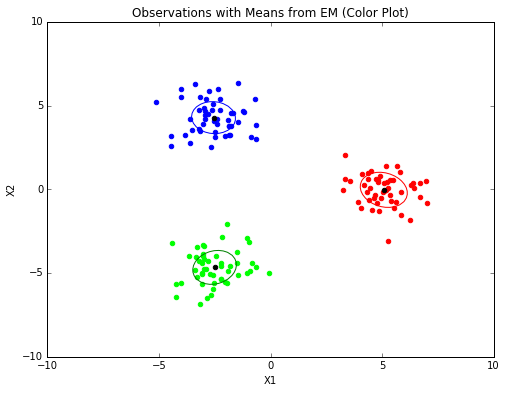


K-Means converged on iteration 14, log likelihood converged (old=-577.39117,new=-577.39117,diff=0.00000).

----------------------------------------------------------
K = 5
----------------------------------------------------------

N: 250 M: 2

Before EM:
Directory anim/M=2/K=5 already exists, clearing files...


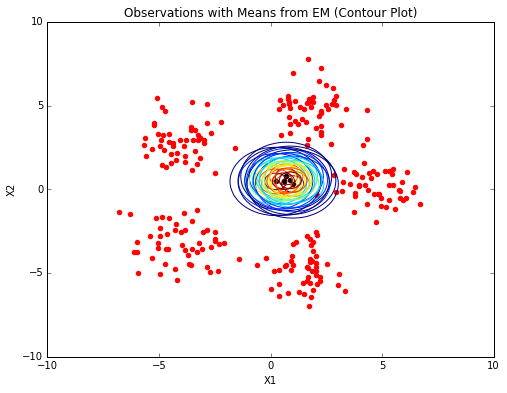


Iteration 1:
Log likelihood: -3771.22822055


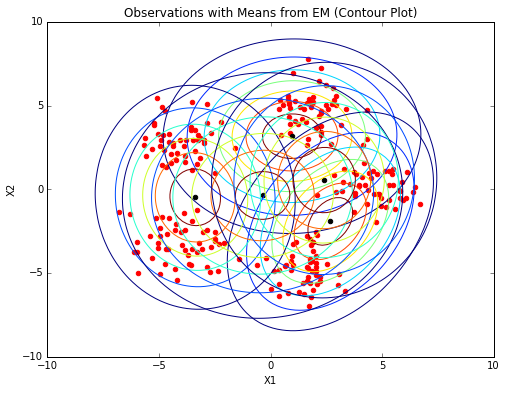


Iteration 2:
Log likelihood: -1328.38102274


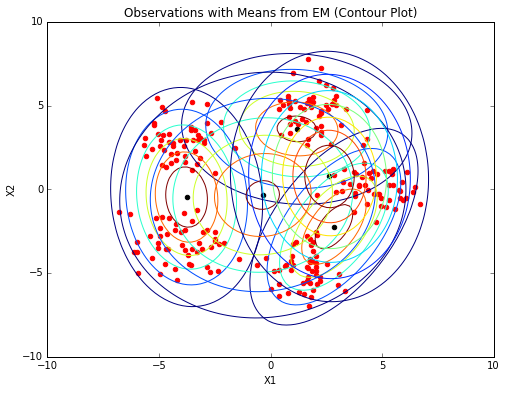


Iteration 3:
Log likelihood: -1292.58519467


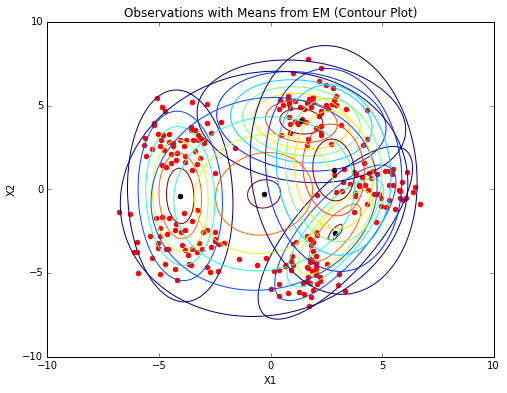


Iteration 4:
Log likelihood: -1250.92966088


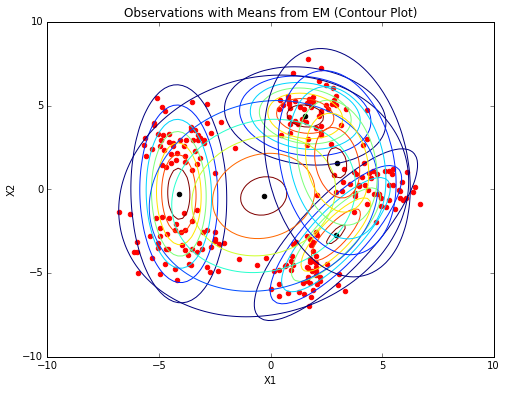


Iteration 5:
Log likelihood: -1231.88847998


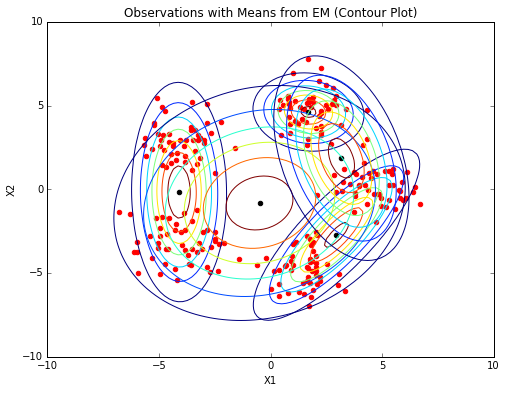


Iteration 6:
Log likelihood: -1216.27068826


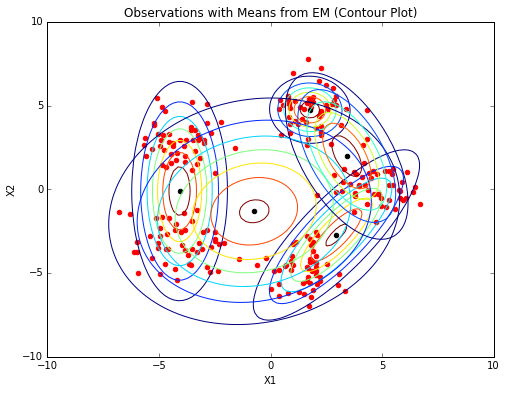


Iteration 7:
Log likelihood: -1206.35012063


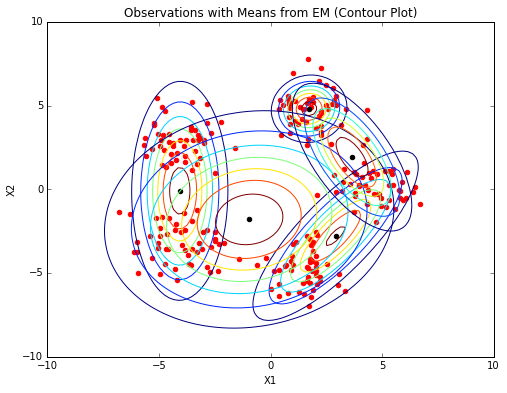


Iteration 8:
Log likelihood: -1202.55088394


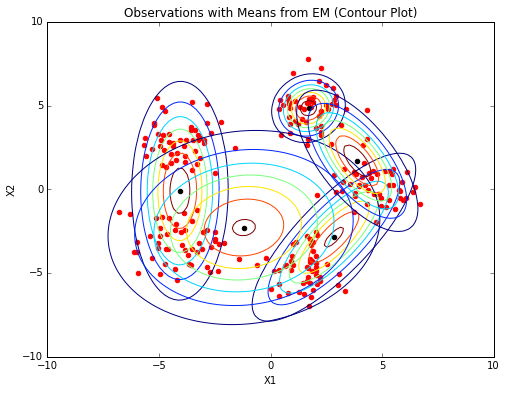


Iteration 9:
Log likelihood: -1200.09114551


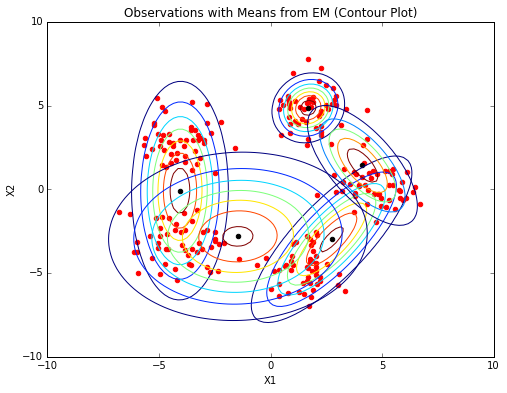


Iteration 10:
Log likelihood: -1197.23796963


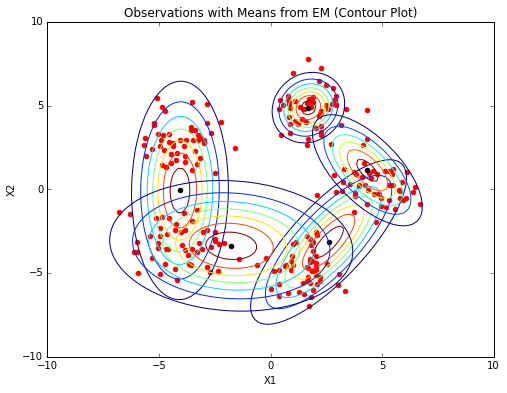


Iteration 11:
Log likelihood: -1192.93556603


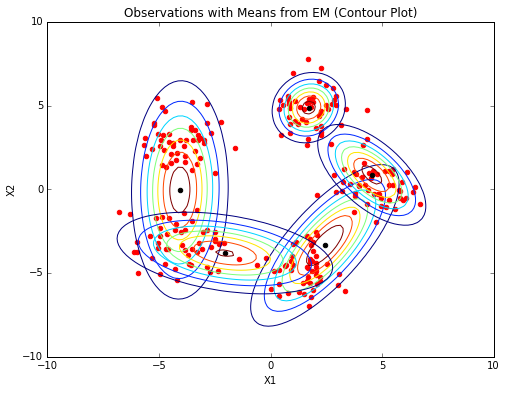


Iteration 12:
Log likelihood: -1184.64728373


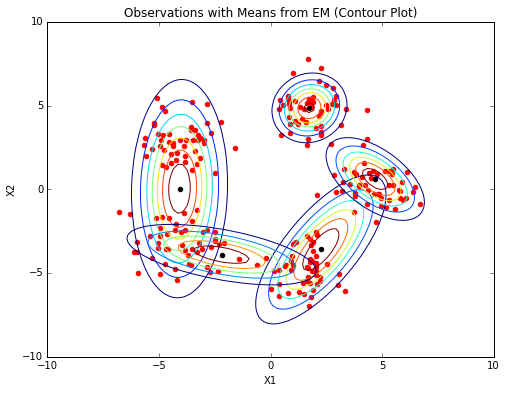


Iteration 13:
Log likelihood: -1174.64615195


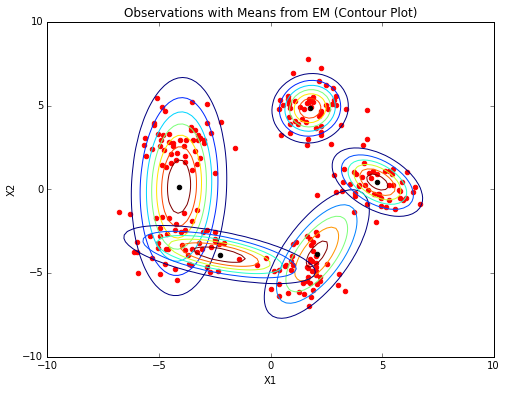


Iteration 14:
Log likelihood: -1165.52546263


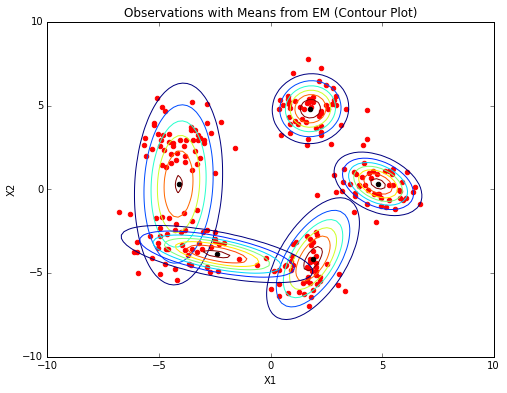


Iteration 15:
Log likelihood: -1158.1522863


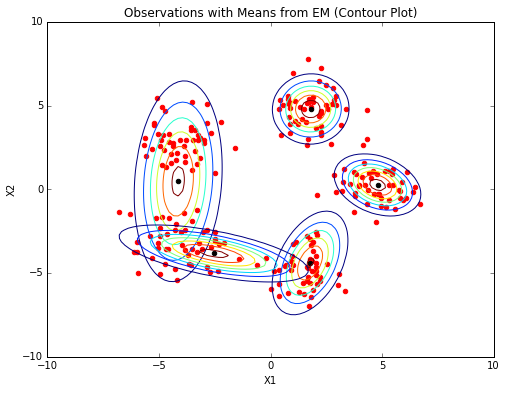


Iteration 16:
Log likelihood: -1151.09784744


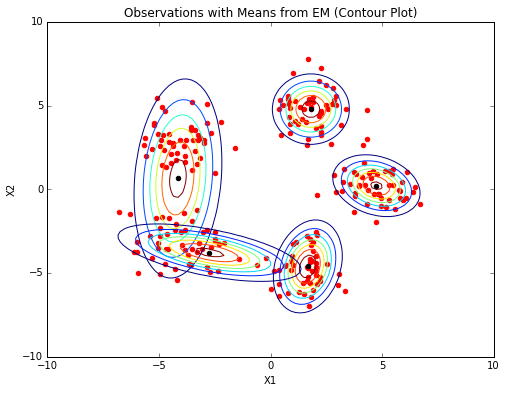


Iteration 17:
Log likelihood: -1144.37453742


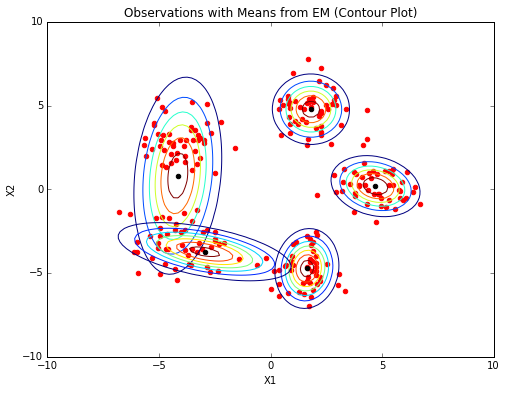


Iteration 18:
Log likelihood: -1140.52425839


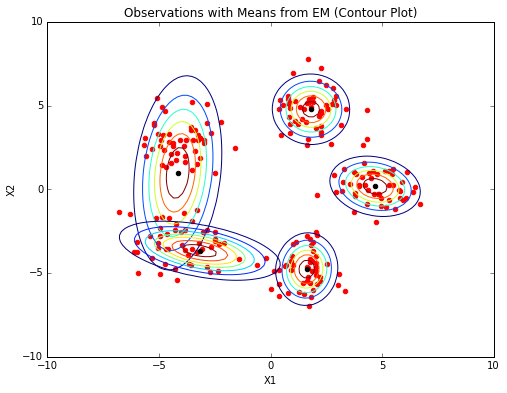


Iteration 19:
Log likelihood: -1138.56315261


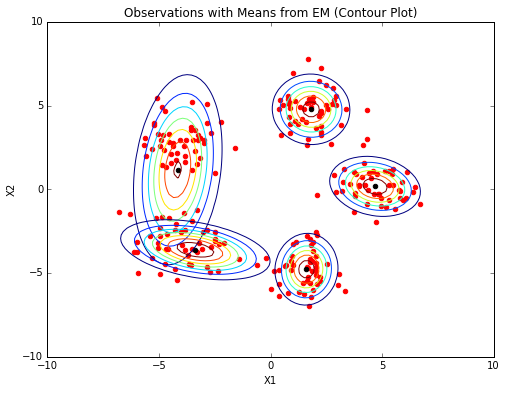


Iteration 20:
Log likelihood: -1136.712929


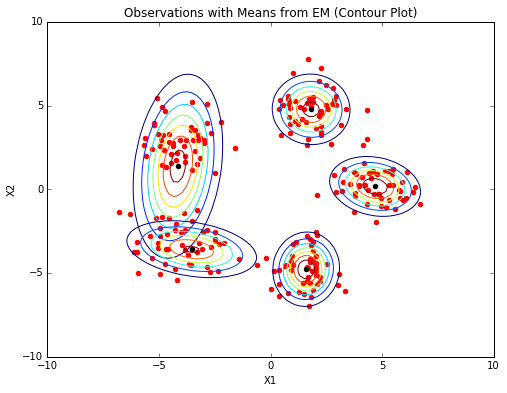


Iteration 21:
Log likelihood: -1134.66443642


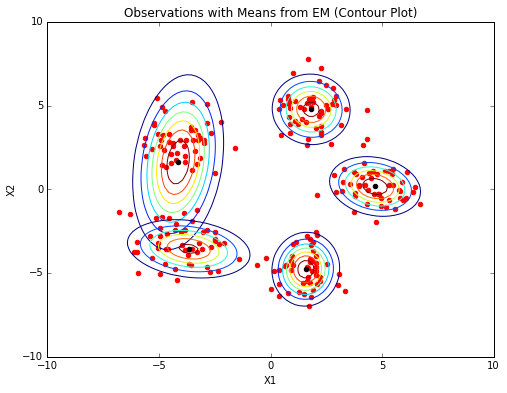


Iteration 22:
Log likelihood: -1132.29041823


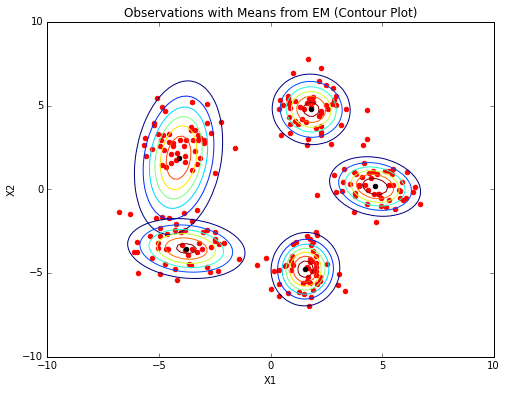


Iteration 23:
Log likelihood: -1129.40976594


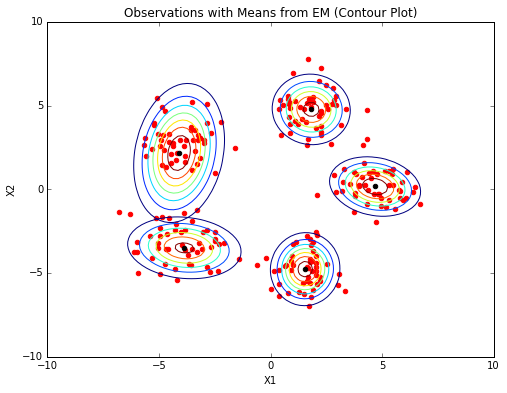


Iteration 24:
Log likelihood: -1125.70248506


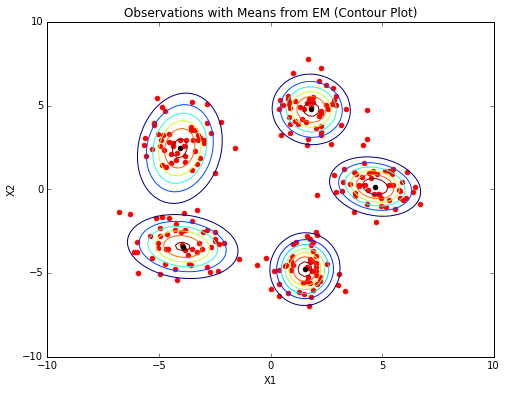


Iteration 25:
Log likelihood: -1120.36746179


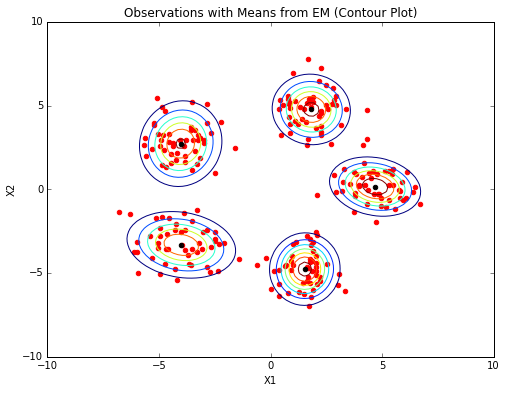


Iteration 26:
Log likelihood: -1113.19033375


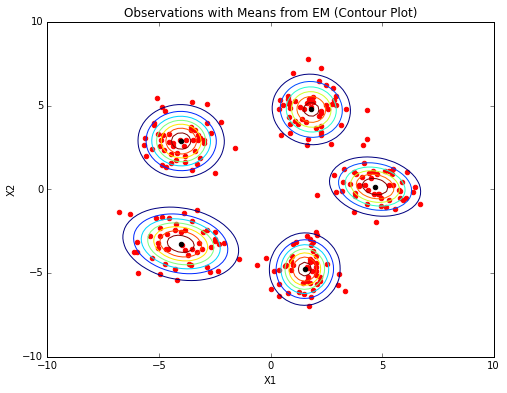


Iteration 27:
Log likelihood: -1110.00042062


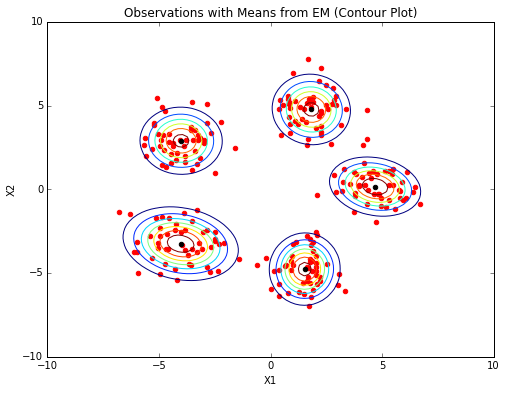


Iteration 28:
Log likelihood: -1109.93785202


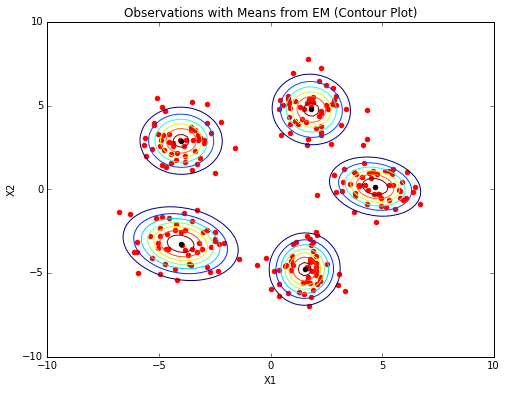


Iteration 29:
Log likelihood: -1109.93726586


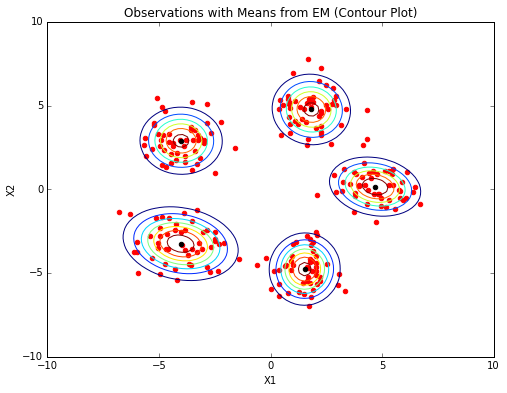


K-Means converged on iteration 29, log likelihood converged (old=-1109.93785,new=-1109.93727,diff=0.00059).



In [7]:
### ~~~~~ Runtime ~~~~~ ###

#X = npm.ones((5,3))
#(X_circles,Y_circles,X,Y_unimodal,X_spiral,Y_spiral,X_bimodal,Y_bimodal) = getSpecialData()
#(X,Y) = getKeeneData(50,50)
#EM(X,K=2)

# Delay between each frame of animation
# Why is this so fast???
delay = 30

print '----------------------------------------------------------'
print ('1-Feature Dataset')
print '----------------------------------------------------------\n'

K=3
print '----------------------------------------------------------'
print ('K = %d' % (K))
print '----------------------------------------------------------\n'
size = 20
X = generate1DClusters(K,[size,size,size])
M = X.shape[1]
(gamma,mu,cov,pi,log_likelihood,frames) = EM(X,K=K,histogram_scale=size)
generateAnimation(M,K,delay)
print 

print '----------------------------------------------------------'
print ('2-Feature Datasets')
print '----------------------------------------------------------\n'

K=2
print '----------------------------------------------------------'
print ('K = %d' % (K))
print '----------------------------------------------------------\n'
X = generateClusters(K,[50,50,50,50,50],r=5)
M = X.shape[1]
(gamma,mu,cov,pi,log_likelihood,frames) = EM(X,K=K)
generateAnimation(M,K,delay)
print

K=3
print '----------------------------------------------------------'
print ('K = %d' % (K))
print '----------------------------------------------------------\n'
X = generateClusters(K,[50,50,50,50,50],r=5)
M = X.shape[1]
(gamma,mu,cov,pi,log_likelihood,frames) = EM(X,K=K)
generateAnimation(M,K,delay)
print

K=5
print '----------------------------------------------------------'
print ('K = %d' % (K))
print '----------------------------------------------------------\n'
X = generateClusters(K,[50,50,50,50,50],r=5)
M = X.shape[1]
(gamma,mu,cov,pi,log_likelihood,frames) = EM(X,K=K)
generateAnimation(M,K,delay)
print

In [8]:
# If there's an issue with the gif, use this to regenerate
delay = 200 # This should be 2 seconds but it's pretty fast... w/e
generateAnimation(1,3,delay)
generateAnimation(2,2,delay)
generateAnimation(2,3,delay)
generateAnimation(2,5,delay)

In [9]:
# Delete extraneous files after gif is generated
cleanup()